In [20]:
import images_generator
import model
import config
import utils
from keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten, Input
import tensorflow as tf
from keras.callbacks import ModelCheckpoint
import json
from tensorflow.keras.utils import plot_model

from keras.optimizers import SGD, RMSprop, Adam, Adagrad

## TREINO MODELO DE SEGMENTAÇÃO

In [21]:
total_train_images = utils.total_count_files(config.TRAIN_DIR_SEG)
print(total_train_images)

total_val_images = utils.total_count_files(config.LABEL_DIR_SEG)
print(total_val_images)

20
20


In [22]:
train_dataset, test_dataset, valida_dataset, len_train, len_test, len_val = images_generator.seg_gen()

In [23]:
input_shape = (config.image_size)
input_tensor = Input(input_shape)

In [24]:
seg_model = model.model_segmentation(input_tensor)

In [25]:
seg_model.compile(optimizer = 'adam', loss = 'binary_crossentropy',
                            metrics = ['accuracy'])

In [26]:
seg_model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_238 (Conv2D)            (None, 256, 256, 32  896         ['input_4[0][0]']                
                                )                                                                 
                                                                                                  
 dropout_22 (Dropout)           (None, 256, 256, 32  0           ['conv2d_238[0][0]']             
                                )                                                           

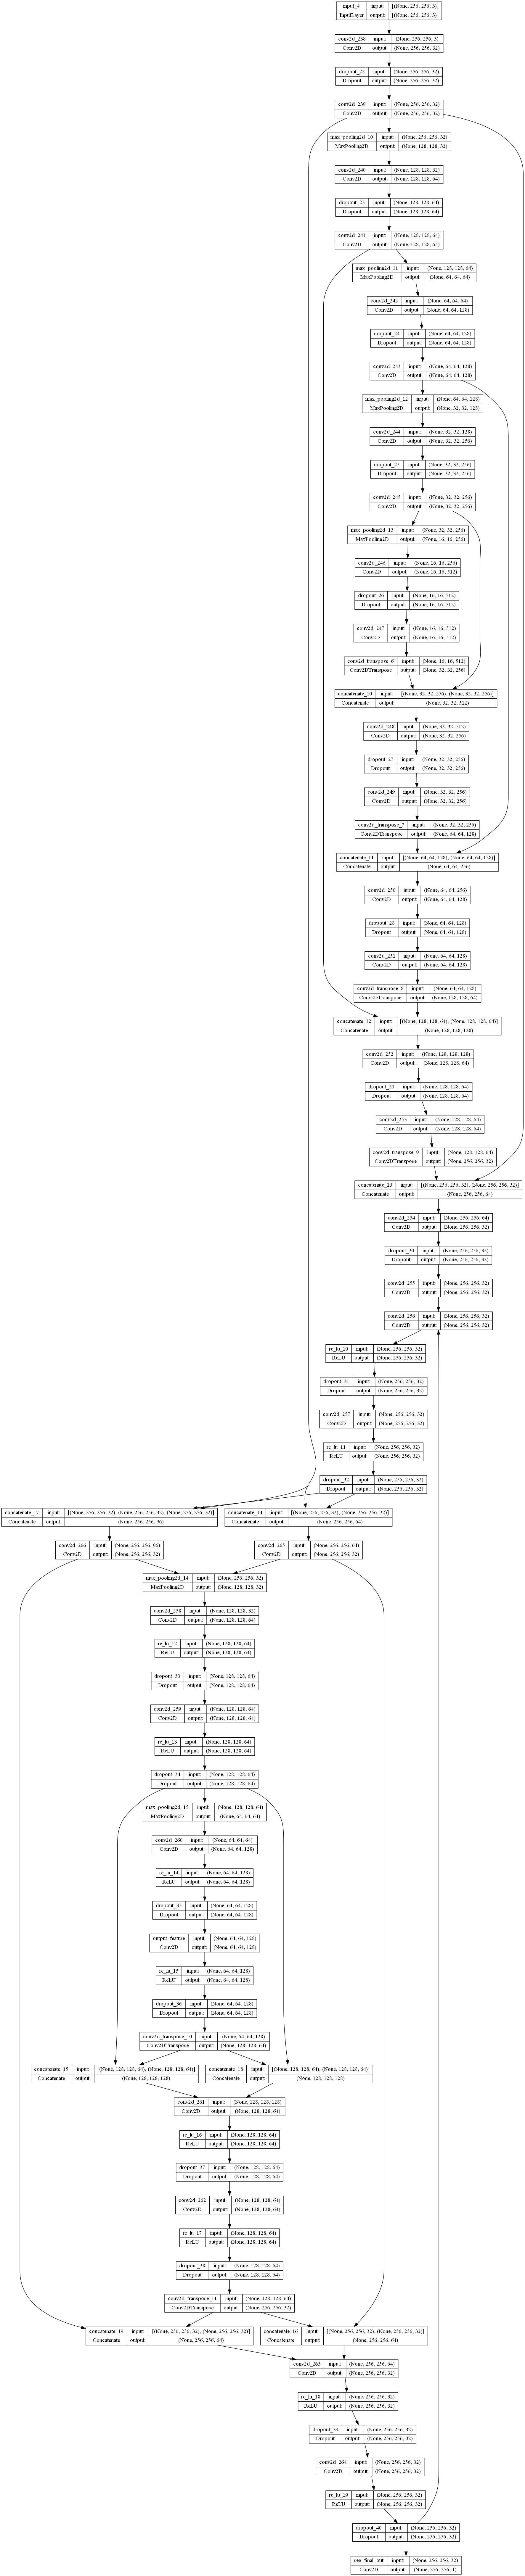

In [27]:
plot_model(seg_model, "output/segmentacao.png", show_shapes=True)

In [28]:
batch = 5

history = utils.LossHistory()
early_stopping = utils.set_early_stopping('accuracy')
reduce_lr = utils.set_reduce_lr()

checkpoint_path = 'output/segmentacao/teste_25_02.h5'

checkpoint = ModelCheckpoint(checkpoint_path, 
                             monitor='accuracy', 
                             verbose=1, 
                             save_best_only=True, 
                             mode='max')

callbacks = [
        early_stopping,
        history,
        tf.keras.callbacks.TensorBoard(log_dir='logs/seg_final/'),
        checkpoint]


#### Visualizando datasets

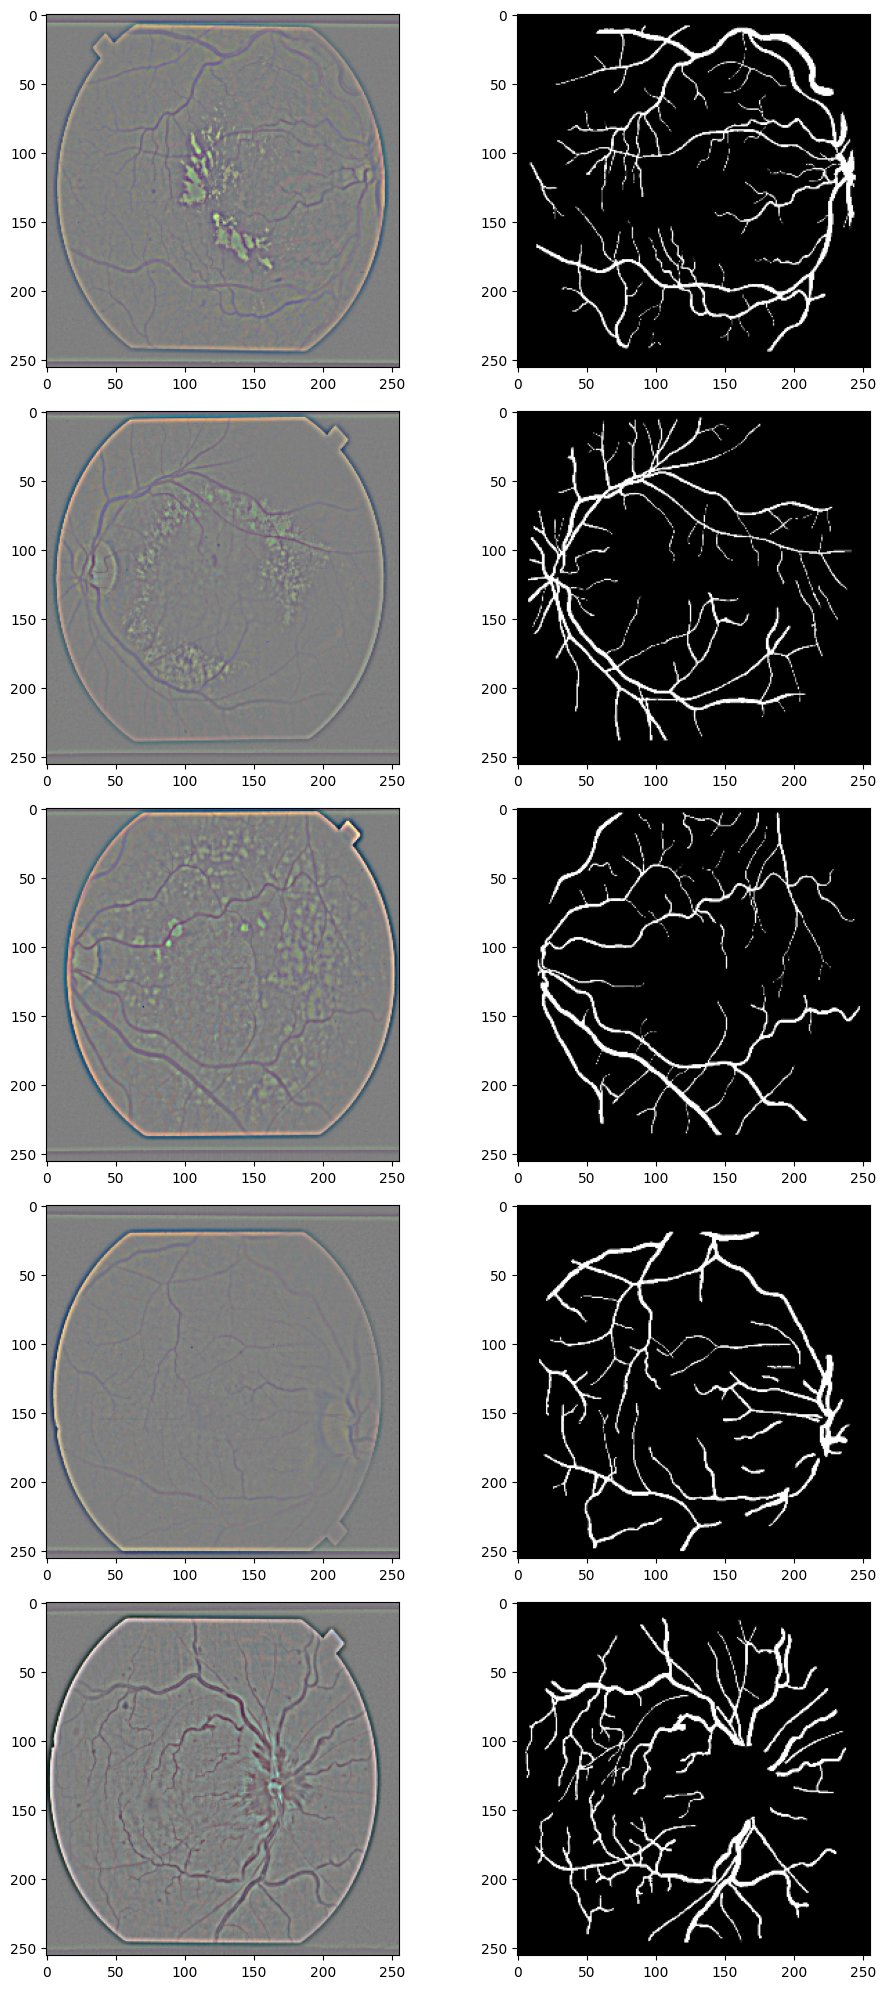

In [8]:
images_generator.visualize_dataset_seg(next(train_dataset))

In [53]:
steps_train = int(len_train // batch)
steps_val = int(len_test // batch)

hist = seg_model.fit(train_dataset,
                    batch_size=5,
                    epochs = 30,
                    steps_per_epoch = steps_train*50,
                    callbacks=callbacks,
                    validation_data = test_dataset,
                    validation_steps = steps_val,
                    shuffle=True
                    )


Epoch 1/30
150/150 [==============================] - ETA: 0s - loss: 0.0960 - accuracy: 0.9340 WARNING:tensorflow:Early stopping conditioned on metric `val_categorical_accuracy` which is not available. Available metrics are: loss,accuracy

Epoch 1: accuracy improved from -inf to 0.93397, saving model to output/segmentacao\teste_25_02.h5
150/150 [==============================] - 1620s 11s/step - loss: 0.0960 - accuracy: 0.9340
Epoch 2/30
150/150 [==============================] - ETA: 0s - loss: 0.0845 - accuracy: 0.9372 WARNING:tensorflow:Early stopping conditioned on metric `val_categorical_accuracy` which is not available. Available metrics are: loss,accuracy

Epoch 2: accuracy improved from 0.93397 to 0.93724, saving model to output/segmentacao\teste_25_02.h5
150/150 [==============================] - 1628s 11s/step - loss: 0.0845 - accuracy: 0.9372
Epoch 3/30
150/150 [==============================] - ETA: 0s - loss: 0.0768 - accuracy: 0.9394 WARNING:tensorflow:Early stopping con

In [54]:

seg_model.save_weights('output/segmentacao/pesos_final_seg.h5')
seg_model.save('output/segmentacao/model_seg')

with open('./output/segmentacao/history_seg.json', 'w') as h:
    json.dump(str(hist.history), h)

INFO:tensorflow:Assets written to: output/segmentacao/model_seg\assets


INFO:tensorflow:Assets written to: output/segmentacao/model_seg\assets


In [9]:
seg_model.load_weights('output/segmentacao/teste_25_02.h5')

In [ ]:
eval = seg_model.evaluate(valida_dataset)

#### visualizando resultados da segmentação

In [10]:
import matplotlib.pyplot as plt
import cv2
import numpy as np

In [11]:
def gaussian_filter(image):
    sigmaX = 10
    return cv2.addWeighted(image, 4, cv2.GaussianBlur(image, (0,0), sigmaX), -4, 128)

In [12]:
image_original = cv2.imread('./datasets/PROCESSED/TREINO/1/parte_3_1362.png')
image = gaussian_filter(image_original)
image = cv2.resize(image, (256,256))
img_tensor = np.expand_dims(image, axis=0)

In [13]:
seg_model.load_weights('./output/segmentacao/teste_25_02.h5')

In [14]:
result = seg_model.predict(img_tensor)

1/1 [==============================] - 1s 940ms/step


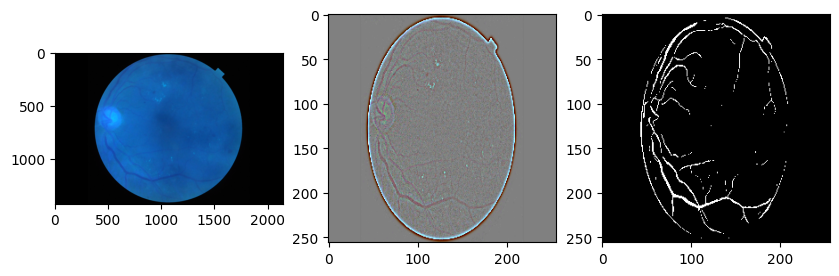

In [15]:
output_2d = result.squeeze()

fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(10, 10))
axs[0].imshow(image_original)
axs[1].imshow(image)
axs[2].imshow(output_2d, cmap='gray')
plt.show()

## TREINO MODELO DE CLASSIFICAÇÃO (INCEPTION) COM ATENÇÃO

In [29]:
total_train_images = utils.total_count_files(config.TRAIN_DIR)
print(total_train_images)

total_val_images = utils.total_count_files(config.TESTE_DIR)
print(total_val_images)

steps_train = int(total_train_images // config.batch)
steps_val = int(total_val_images // config.batch)

1082
471


In [47]:
steps_train

67

In [30]:
train_dataset_c, test_dateset_c = images_generator.inception_gen()

Found 909 files belonging to 2 classes.
Found 392 files belonging to 2 classes.


TypeError: only integer scalar arrays can be converted to a scalar index

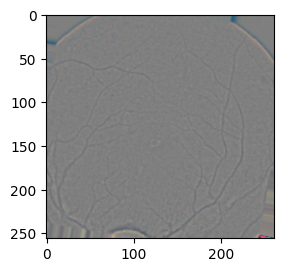

In [31]:
## visualizar os dados

images_generator.visualize_dataset_inception(train_dataset_c)

In [37]:
input_shape = (config.image_size)
input_tensor = Input(input_shape)

In [38]:
model_inception = model.custom_inceptionV2_attention(input_tensor)

base_model loaded


In [39]:
model_inception.summary()

Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 inception_resnet_v2 (Functiona  (None, 6, 6, 1536)  54336736    ['input_7[0][0]']                
 l)                                                                                               
                                                                                                  
 batch_normalization_611 (Batch  (None, 6, 6, 1536)  6144        ['inception_resnet_v2[1][0]']    
 Normalization)                                                                             

In [40]:
optimizer = SGD(learning_rate=1e-3,
              momentum=0.9,
              nesterov=True)
optimizer_rms = RMSprop(learning_rate=0.0001, rho=0.9, epsilon=None, decay=0.0)

optimizer_adam = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

optimizer_adagrad = Adagrad(learning_rate=0.001, epsilon=None, decay=0.0)
    
objective="categorical_crossentropy"

In [44]:
model_inception.compile(optimizer=optimizer_adam,
              loss=objective,
              metrics=['categorical_accuracy', 'accuracy']
              )

In [45]:
batch = 5
history = utils.LossHistory()
early_stopping = utils.set_early_stopping('accuracy')
reduce_lr = utils.set_reduce_lr()

checkpoint_path = 'output/inceptionv2/attention/teste_fix_generator_25_02.h5'

steps_train = int(total_train_images // config.batch)
steps_val = int(total_val_images // config.batch)

checkpoint = ModelCheckpoint(checkpoint_path, 
                             monitor='accuracy', 
                             verbose=1, 
                             save_best_only=True, 
                             mode='max')


# TESTAR 2 NOS NA SAIDA COM ATIVACAO SOFTMAX

In [46]:

hist = model_inception.fit(train_dataset_c.repeat(),
                    epochs = 50, #config.epochs,
                    callbacks=[history, reduce_lr, checkpoint],
                    validation_data = test_dateset_c
                    )

seg_model.save_weights('output/inceptionv2/attention/pesos_final_fixed_input_class.h5')
seg_model.save('output/inceptionv2/attention/model_class_fixed_input')

with open('./output/inceptionv2/history_seg.json', 'w') as h:
    json.dump(str(hist.history), h)

Epoch 1/50
134/134 [==============================] - ETA: 0s - loss: 0.0000e+00 - categorical_accuracy: 1.0000 - accuracy: 0.5192WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 29 batches). You may need to use the repeat() function when building your dataset.



Epoch 1: accuracy improved from -inf to 0.51918, saving model to output/inceptionv2/attention\teste_fix_generator_25_02.h5
134/134 [==============================] - 571s 4s/step - loss: 0.0000e+00 - categorical_accuracy: 1.0000 - accuracy: 0.5192 - val_loss: 0.0000e+00 - val_categorical_accuracy: 1.0000 - val_accuracy: 0.5026 - lr: 0.0010
Epoch 2/50
134/134 [==============================] - ETA: 0s - loss: nan - categorical_accuracy: 1.0000 - accuracy: 0.5187WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,categorical_accuracy,accuracy,lr



Epoch 2: accuracy did not improve from 0.51918
134/134 [==============================] - 443s 3s/step - loss: nan - categorical_accuracy: 1.0000 - accuracy: 0.5187 - lr: 0.0010
Epoch 3/50
134/134 [==============================] - ETA: 0s - loss: nan - categorical_accuracy: 1.0000 - accuracy: 0.5157WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,categorical_accuracy,accuracy,lr



Epoch 3: accuracy did not improve from 0.51918
134/134 [==============================] - 449s 3s/step - loss: nan - categorical_accuracy: 1.0000 - accuracy: 0.5157 - lr: 0.0010
Epoch 4/50
134/134 [==============================] - ETA: 0s - loss: nan - categorical_accuracy: 1.0000 - accuracy: 0.5187WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,categorical_accuracy,accuracy,lr



Epoch 4: accuracy did not improve from 0.51918
134/134 [==============================] - 431s 3s/step - loss: nan - categorical_accuracy: 1.0000 - accuracy: 0.5187 - lr: 0.0010
Epoch 5/50
134/134 [==============================] - ETA: 0s - loss: nan - categorical_accuracy: 1.0000 - accuracy: 0.5285WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,categorical_accuracy,accuracy,lr



Epoch 5: accuracy improved from 0.51918 to 0.52853, saving model to output/inceptionv2/attention\teste_fix_generator_25_02.h5
134/134 [==============================] - 438s 3s/step - loss: nan - categorical_accuracy: 1.0000 - accuracy: 0.5285 - lr: 0.0010
Epoch 6/50
134/134 [==============================] - ETA: 0s - loss: nan - categorical_accuracy: 1.0000 - accuracy: 0.5143WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,categorical_accuracy,accuracy,lr



Epoch 6: accuracy did not improve from 0.52853
134/134 [==============================] - 436s 3s/step - loss: nan - categorical_accuracy: 1.0000 - accuracy: 0.5143 - lr: 0.0010
Epoch 7/50
134/134 [==============================] - ETA: 0s - loss: nan - categorical_accuracy: 1.0000 - accuracy: 0.5229WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,categorical_accuracy,accuracy,lr



Epoch 7: accuracy did not improve from 0.52853
134/134 [==============================] - 438s 3s/step - loss: nan - categorical_accuracy: 1.0000 - accuracy: 0.5229 - lr: 0.0010
Epoch 8/50
134/134 [==============================] - ETA: 0s - loss: nan - categorical_accuracy: 1.0000 - accuracy: 0.5140WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,categorical_accuracy,accuracy,lr



Epoch 8: accuracy did not improve from 0.52853
134/134 [==============================] - 424s 3s/step - loss: nan - categorical_accuracy: 1.0000 - accuracy: 0.5140 - lr: 0.0010
Epoch 9/50
134/134 [==============================] - ETA: 0s - loss: nan - categorical_accuracy: 1.0000 - accuracy: 0.5199WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,categorical_accuracy,accuracy,lr



Epoch 9: accuracy did not improve from 0.52853
134/134 [==============================] - 436s 3s/step - loss: nan - categorical_accuracy: 1.0000 - accuracy: 0.5199 - lr: 0.0010
Epoch 10/50
134/134 [==============================] - ETA: 0s - loss: nan - categorical_accuracy: 1.0000 - accuracy: 0.5267WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,categorical_accuracy,accuracy,lr



Epoch 10: accuracy did not improve from 0.52853
134/134 [==============================] - 437s 3s/step - loss: nan - categorical_accuracy: 1.0000 - accuracy: 0.5267 - lr: 0.0010
Epoch 11/50
134/134 [==============================] - ETA: 0s - loss: nan - categorical_accuracy: 1.0000 - accuracy: 0.5094WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,categorical_accuracy,accuracy,lr



Epoch 11: accuracy did not improve from 0.52853
134/134 [==============================] - 421s 3s/step - loss: nan - categorical_accuracy: 1.0000 - accuracy: 0.5094 - lr: 0.0010
Epoch 12/50
134/134 [==============================] - ETA: 0s - loss: nan - categorical_accuracy: 1.0000 - accuracy: 0.5213WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,categorical_accuracy,accuracy,lr



Epoch 12: accuracy did not improve from 0.52853
134/134 [==============================] - 446s 3s/step - loss: nan - categorical_accuracy: 1.0000 - accuracy: 0.5213 - lr: 0.0010
Epoch 13/50
134/134 [==============================] - ETA: 0s - loss: nan - categorical_accuracy: 1.0000 - accuracy: 0.5210WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,categorical_accuracy,accuracy,lr



Epoch 13: accuracy did not improve from 0.52853
134/134 [==============================] - 428s 3s/step - loss: nan - categorical_accuracy: 1.0000 - accuracy: 0.5210 - lr: 0.0010
Epoch 14/50
134/134 [==============================] - ETA: 0s - loss: nan - categorical_accuracy: 1.0000 - accuracy: 0.5168WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,categorical_accuracy,accuracy,lr



Epoch 14: accuracy did not improve from 0.52853
134/134 [==============================] - 433s 3s/step - loss: nan - categorical_accuracy: 1.0000 - accuracy: 0.5168 - lr: 0.0010
Epoch 15/50
134/134 [==============================] - ETA: 0s - loss: nan - categorical_accuracy: 1.0000 - accuracy: 0.5227WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,categorical_accuracy,accuracy,lr



Epoch 15: accuracy did not improve from 0.52853
134/134 [==============================] - 433s 3s/step - loss: nan - categorical_accuracy: 1.0000 - accuracy: 0.5227 - lr: 0.0010
Epoch 16/50
134/134 [==============================] - ETA: 0s - loss: nan - categorical_accuracy: 1.0000 - accuracy: 0.5225WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,categorical_accuracy,accuracy,lr



Epoch 16: accuracy did not improve from 0.52853
134/134 [==============================] - 440s 3s/step - loss: nan - categorical_accuracy: 1.0000 - accuracy: 0.5225 - lr: 0.0010
Epoch 17/50
134/134 [==============================] - ETA: 0s - loss: nan - categorical_accuracy: 1.0000 - accuracy: 0.5136WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,categorical_accuracy,accuracy,lr



Epoch 17: accuracy did not improve from 0.52853
134/134 [==============================] - 428s 3s/step - loss: nan - categorical_accuracy: 1.0000 - accuracy: 0.5136 - lr: 0.0010
Epoch 18/50
134/134 [==============================] - ETA: 0s - loss: nan - categorical_accuracy: 1.0000 - accuracy: 0.5218WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,categorical_accuracy,accuracy,lr



Epoch 18: accuracy did not improve from 0.52853
134/134 [==============================] - 445s 3s/step - loss: nan - categorical_accuracy: 1.0000 - accuracy: 0.5218 - lr: 0.0010
Epoch 19/50
134/134 [==============================] - ETA: 0s - loss: nan - categorical_accuracy: 1.0000 - accuracy: 0.5206WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,categorical_accuracy,accuracy,lr



Epoch 19: accuracy did not improve from 0.52853
134/134 [==============================] - 427s 3s/step - loss: nan - categorical_accuracy: 1.0000 - accuracy: 0.5206 - lr: 0.0010
Epoch 20/50
134/134 [==============================] - ETA: 0s - loss: nan - categorical_accuracy: 1.0000 - accuracy: 0.5157WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,categorical_accuracy,accuracy,lr



Epoch 20: accuracy did not improve from 0.52853
134/134 [==============================] - 439s 3s/step - loss: nan - categorical_accuracy: 1.0000 - accuracy: 0.5157 - lr: 0.0010
Epoch 21/50
134/134 [==============================] - ETA: 0s - loss: nan - categorical_accuracy: 1.0000 - accuracy: 0.5234WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,categorical_accuracy,accuracy,lr



Epoch 21: accuracy did not improve from 0.52853
134/134 [==============================] - 419s 3s/step - loss: nan - categorical_accuracy: 1.0000 - accuracy: 0.5234 - lr: 0.0010
Epoch 22/50
134/134 [==============================] - ETA: 0s - loss: nan - categorical_accuracy: 1.0000 - accuracy: 0.5182WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,categorical_accuracy,accuracy,lr



Epoch 22: accuracy did not improve from 0.52853
134/134 [==============================] - 431s 3s/step - loss: nan - categorical_accuracy: 1.0000 - accuracy: 0.5182 - lr: 0.0010
Epoch 23/50
134/134 [==============================] - ETA: 0s - loss: nan - categorical_accuracy: 1.0000 - accuracy: 0.5148WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,categorical_accuracy,accuracy,lr



Epoch 23: accuracy did not improve from 0.52853
134/134 [==============================] - 420s 3s/step - loss: nan - categorical_accuracy: 1.0000 - accuracy: 0.5148 - lr: 0.0010
Epoch 24/50
134/134 [==============================] - ETA: 0s - loss: nan - categorical_accuracy: 1.0000 - accuracy: 0.5248WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,categorical_accuracy,accuracy,lr



Epoch 24: accuracy did not improve from 0.52853
134/134 [==============================] - 435s 3s/step - loss: nan - categorical_accuracy: 1.0000 - accuracy: 0.5248 - lr: 0.0010
Epoch 25/50
134/134 [==============================] - ETA: 0s - loss: nan - categorical_accuracy: 1.0000 - accuracy: 0.5173WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,categorical_accuracy,accuracy,lr



Epoch 25: accuracy did not improve from 0.52853
134/134 [==============================] - 420s 3s/step - loss: nan - categorical_accuracy: 1.0000 - accuracy: 0.5173 - lr: 0.0010
Epoch 26/50
134/134 [==============================] - ETA: 0s - loss: nan - categorical_accuracy: 1.0000 - accuracy: 0.5222WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,categorical_accuracy,accuracy,lr



Epoch 26: accuracy did not improve from 0.52853
134/134 [==============================] - 442s 3s/step - loss: nan - categorical_accuracy: 1.0000 - accuracy: 0.5222 - lr: 0.0010
Epoch 27/50
134/134 [==============================] - ETA: 0s - loss: nan - categorical_accuracy: 1.0000 - accuracy: 0.5173WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,categorical_accuracy,accuracy,lr



Epoch 27: accuracy did not improve from 0.52853
134/134 [==============================] - 418s 3s/step - loss: nan - categorical_accuracy: 1.0000 - accuracy: 0.5173 - lr: 0.0010
Epoch 28/50
134/134 [==============================] - ETA: 0s - loss: nan - categorical_accuracy: 1.0000 - accuracy: 0.5154WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,categorical_accuracy,accuracy,lr



Epoch 28: accuracy did not improve from 0.52853
134/134 [==============================] - 425s 3s/step - loss: nan - categorical_accuracy: 1.0000 - accuracy: 0.5154 - lr: 0.0010
Epoch 29/50
134/134 [==============================] - ETA: 0s - loss: nan - categorical_accuracy: 1.0000 - accuracy: 0.5176WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,categorical_accuracy,accuracy,lr



Epoch 29: accuracy did not improve from 0.52853
134/134 [==============================] - 424s 3s/step - loss: nan - categorical_accuracy: 1.0000 - accuracy: 0.5176 - lr: 0.0010
Epoch 30/50
134/134 [==============================] - ETA: 0s - loss: nan - categorical_accuracy: 1.0000 - accuracy: 0.5262WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,categorical_accuracy,accuracy,lr



Epoch 30: accuracy did not improve from 0.52853
134/134 [==============================] - 429s 3s/step - loss: nan - categorical_accuracy: 1.0000 - accuracy: 0.5262 - lr: 0.0010
Epoch 31/50
134/134 [==============================] - ETA: 0s - loss: nan - categorical_accuracy: 1.0000 - accuracy: 0.5126WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,categorical_accuracy,accuracy,lr



Epoch 31: accuracy did not improve from 0.52853
134/134 [==============================] - 471s 4s/step - loss: nan - categorical_accuracy: 1.0000 - accuracy: 0.5126 - lr: 0.0010
Epoch 32/50
127/134 [===========================>..] - ETA: 22s - loss: nan - categorical_accuracy: 1.0000 - accuracy: 0.5220

KeyboardInterrupt: 

In [19]:
model_inception.evaluate(test_dateset_c)

25/25 [==============================] - 63s 2s/step - loss: 0.7721 - accuracy: 0.6837


[0.7720746994018555, 0.6836734414100647]

In [79]:
train_dataset_c

<MapDataset element_spec=(TensorSpec(shape=(None, None, None, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>